In [2]:
# !pip install -r requirements.txt

In [3]:
import argparse
import os
os.environ['CUDA_HOME'] = '/usr/local/cuda'
os.environ['PATH'] = os.environ['PATH'] + ':/usr/local/cuda/bin'
from datetime import datetime

# import gradio as gr
# import spaces
import numpy as np
import torch
from diffusers.image_processor import VaeImageProcessor
from huggingface_hub import snapshot_download
from PIL import Image
torch.jit.script = lambda f: f
from model.cloth_masker import AutoMasker, vis_mask
from model.pipeline import CatVTONPipeline
from utils import init_weight_dtype, resize_and_crop, resize_and_padding

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


In [5]:
repo_path = snapshot_download(repo_id='zhengchong/CatVTON')
# Pipeline
pipeline = CatVTONPipeline(
    base_ckpt='runwayml/stable-diffusion-inpainting',
    attn_ckpt=repo_path,
    attn_ckpt_version="mix",
    weight_dtype=init_weight_dtype("bf16"),
    use_tf32=True,
    device='cuda'
)
# AutoMasker
mask_processor = VaeImageProcessor(vae_scale_factor=8, do_normalize=False, do_binarize=True, do_convert_grayscale=True)
automasker = AutoMasker(
    densepose_ckpt=os.path.join(repo_path, "DensePose"),
    schp_ckpt=os.path.join(repo_path, "SCHP"),
    device='cuda', 
)


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

(…)nsePose/densepose_rcnn_R_50_FPN_s1x.yaml:   0%|          | 0.00/182 [00:00<?, ?B/s]

DensePose/Base-DensePose-RCNN-FPN.yaml:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model_final_162be9.pkl:   0%|          | 0.00/256M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/198M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/198M [00:00<?, ?B/s]

exp-schp-201908261155-lip.pth:   0%|          | 0.00/267M [00:00<?, ?B/s]

exp-schp-201908301523-atr.pth:   0%|          | 0.00/267M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/198M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

An error occurred while trying to fetch runwayml/stable-diffusion-inpainting: runwayml/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
result_save_path = "resource/demo/output"
width = 768
height = 1024
def submit_function(
    person_image,
    cloth_image,
    cloth_type,
    num_inference_steps,
    guidance_scale,
    seed,
    show_type
):
    # person_image, mask = person_image["background"], person_image["layers"][0]
    # mask = Image.open(mask).convert("L")
    # if len(np.unique(np.array(mask))) == 1:
    #     mask = None
    # else:
    #     mask = np.array(mask)
    #     mask[mask > 0] = 255
    #     mask = Image.fromarray(mask)

    tmp_folder = output_dir
    date_str = datetime.now().strftime("%Y%m%d%H%M%S")
    result_save_path = os.path.join(tmp_folder, date_str[:8], date_str[8:] + ".png")
    if not os.path.exists(os.path.join(tmp_folder, date_str[:8])):
        os.makedirs(os.path.join(tmp_folder, date_str[:8]))

    generator = None
    mask = None
    if seed != -1:
        generator = torch.Generator(device='cuda').manual_seed(seed)

    person_image = Image.open(person_image).convert("RGB")
    cloth_image = Image.open(cloth_image).convert("RGB")
    person_image = resize_and_crop(person_image, (768, 1024))
    cloth_image = resize_and_padding(cloth_image, (768, 1024))
    
    # Process mask
    if mask is not None:
        mask = resize_and_crop(mask, (768, 1024))
    else:
        mask = automasker(
            person_image,
            cloth_type
        )['mask']
    mask = mask_processor.blur(mask, blur_factor=9)

    # Inference
    # try:
    result_image = pipeline(
        image=person_image,
        condition_image=cloth_image,
        mask=mask,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=generator
    )[0]
    # except Exception as e:
    #     raise gr.Error(
    #         "An error occurred. Please try again later: {}".format(e)
    #     )
    
    # Post-process
    masked_person = vis_mask(person_image, mask)
    save_result_image = image_grid([person_image, masked_person, cloth_image, result_image], 1, 4)
    save_result_image.save(result_save_path)
    if show_type == "result only":
        return result_image
    else:
        width, height = person_image.size
        if show_type == "input & result":
            condition_width = width // 2
            conditions = image_grid([person_image, cloth_image], 2, 1)
        else:
            condition_width = width // 3
            conditions = image_grid([person_image, masked_person , cloth_image], 3, 1)
        conditions = conditions.resize((condition_width, height), Image.NEAREST)
        new_result_image = Image.new("RGB", (width + condition_width + 5, height))
        new_result_image.paste(conditions, (0, 0))
        new_result_image.paste(result_image, (condition_width + 5, 0))
    return new_result_image

In [9]:
person_image = 'resource/demo/example/person/men/model_5.png'
cloth_image = 'resource/demo/example/condition/upper/22790049_53294275_1000.jpg'
cloth_type = 'upper'
num_inference_steps = 50
guidance_scale = 2.5
seed = 42
show_type = "result only"
output_dir = '/workspace/CatVTON/output'

In [12]:
out_img = submit_function(
    person_image,
    cloth_image,
    cloth_type,
    num_inference_steps,
    guidance_scale,
    seed,
    show_type
)

100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


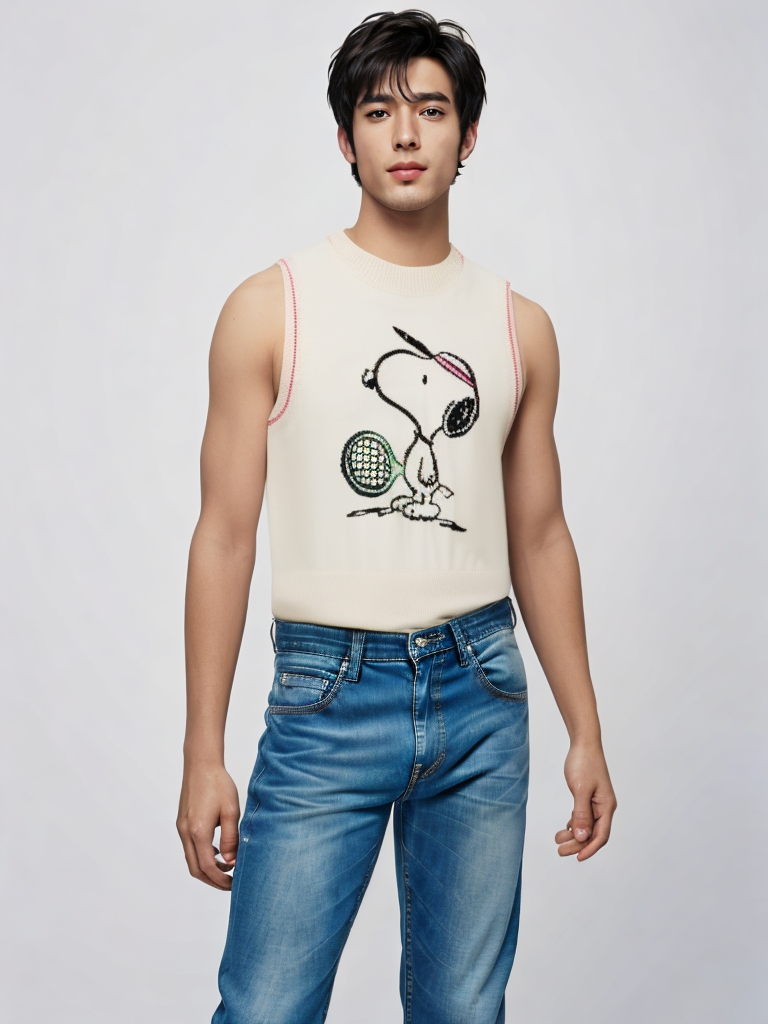

In [13]:
out_img